# Investigating Edinburgh AirBnB Data: What Affects Price and Popularity of a Property?

## 1. Import Libraries and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import names
#note: you will need to ensure you have the names corpus downloaded first with nltk.download()
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('listings.csv', index_col='id')

## 2. Investigating Target Columns

### price

In [3]:
#cleaning the column

def remove_dllr(x):
    '''Takes a string input, removes dollar signs and commas,
    and converts to a float.
    
    Try-except block used because an error is raised when attempting
    to convert NaN to float - in this case, returns the original x.
    '''
    try:
        x = x.replace('$', '')
        x = x.replace(',', '')
        return float(x)
    except:
        return x

df['price'] = df['price'].apply(remove_dllr)

In [4]:
df['price'].describe()

count    12725.000000
mean       140.522358
std        480.793101
min          0.000000
25%         50.000000
50%         79.000000
75%        120.000000
max      20289.000000
Name: price, dtype: float64

Fortunately, no null values.

Seems like we have some very large outliers, considering the max is 20k, but even our 75% mark is only 120.

In [5]:
sum(df['price']<=1000)/12725

0.9964636542239685

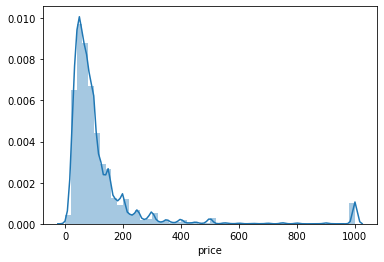

In [6]:
sns.distplot(df[df['price']<=1000]['price'])

Restricting to just max 1000, we are still covering over 99% of rows. However, there is a spike at 1000, and most of the prices are 500 or below.

In [7]:
sum(df['price']<=500)/12725

0.9705304518664047

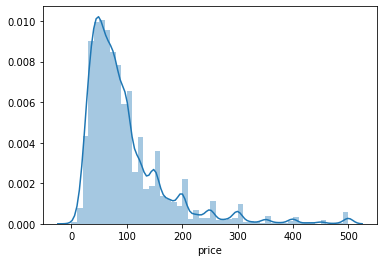

In [8]:
sns.distplot(df[df['price']<=500]['price'])

Limiting the price column to 500 does a good job of keeping the vast majority of cases (over 97%), but removing the outliers.

In [9]:
df = df[df['price']<=500]
print(len(df))

12350


In addition to looking at the absolute price, I want to see the price adjusted by the size of the property (as I expect the size to play a big role in the price). Let's investigate which column to use for this:
- accommodates
- beds
- bedrooms

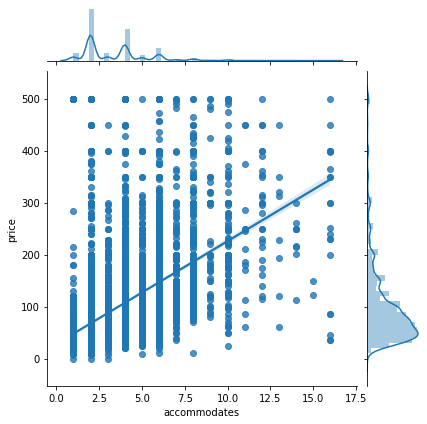

In [10]:
sns.jointplot(x='accommodates', y='price', data=df, kind='reg')

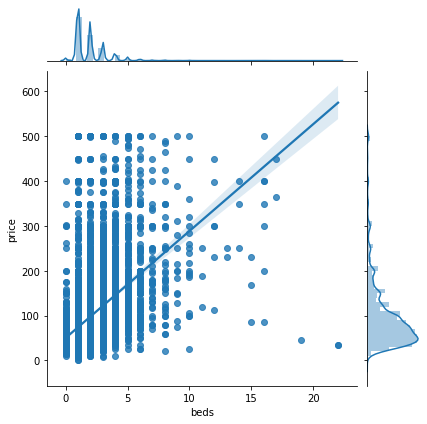

In [11]:
sns.jointplot(x='beds', y='price', data=df, kind='reg')

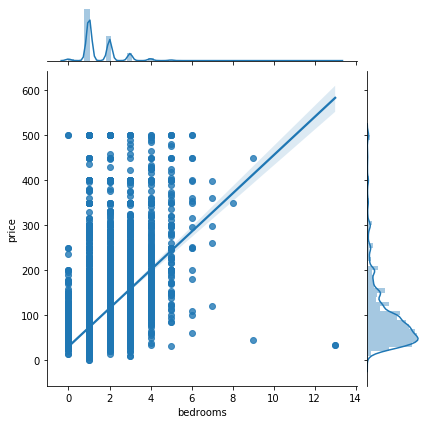

In [12]:
sns.jointplot(x='bedrooms', y='price', data=df, kind='reg')

Based on these charts, I will go with bedrooms. It has a stronger affect on price than accommodates, and a higher confidence than beds. This also makes more intuitive sense, as the numbers for accommodates and beds can be inflated more easily by the property owner (by counting air beds on the floor, for instance).

In [13]:
df['bedrooms'].describe()

count    12342.000000
mean         1.551774
std          0.887954
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         13.000000
Name: bedrooms, dtype: float64

We have some null values, and some high outliers. Will fill in missing values with median, as it is less affected by outliers than mean.

Note: the reason we're filling the nulls at all is because we want to calculate the price per bedroom.

In [14]:
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].median())

In [15]:
#if a property has 0 bedrooms, I want to consider it to have 1 bedroom for the purposes
#of this metric - I don't want to have infinities.
df['price_per_bedroom'] = df['price'] / df['bedrooms'].apply(lambda x: 1 if x == 0 else x)

### availability 

For this, we have a few options:
- availability_30
- availability_60
- availability_90
- availability_365

But let's first see what the columns actually mean.

In [16]:
df['availability_30'].describe()

count    12350.000000
mean         8.511336
std         11.619978
min          0.000000
25%          0.000000
50%          0.000000
75%         24.000000
max         27.000000
Name: availability_30, dtype: float64

In [17]:
df['has_availability'].value_counts()

t    12350
Name: has_availability, dtype: int64

Intuitively, I thought 0 availability would mean it's fully booked. However, every property in the dataset has availability. Thus, the availability columns instead seem to list the number of bookings the property has in the next n days.

In [18]:
df['availability_60'].describe()

count    12350.000000
mean        20.250526
std         23.695563
min          0.000000
25%          0.000000
50%          0.000000
75%         48.000000
max         57.000000
Name: availability_60, dtype: float64

In [19]:
df['availability_90'].describe()

count    12350.000000
mean        31.722753
std         35.015065
min          0.000000
25%          0.000000
50%          9.000000
75%         67.000000
max         87.000000
Name: availability_90, dtype: float64

In [20]:
df['availability_365'].describe()

count    12350.000000
mean       100.711822
std        122.272996
min          0.000000
25%          0.000000
50%         48.000000
75%        176.000000
max        362.000000
Name: availability_365, dtype: float64

Overall, there is very few bookings made in the near future. This makes sense due to the current coronavirus situation. I'll want to choose one of the longer periods of time than 30 to account for this.

However, I don't want to take too long a period, as this will get more impacted by outlier properties with a lot of bookings very far in advance (like the property with 362 days booked already).

The availability_90 column seems like a happy middle ground.

In [21]:
#let's change the name of availability_90 to clarify what it means
df['bookings_90'] = df['availability_90']

In [22]:
#saving a list of final metrics for convenience
metrics = [
    'price',
    'price_per_bedroom',
    'bookings_90'
]

## 3. Neighbourhood

Intuitively, this feels like it'll have a big difference on price, but let's see if that holds true in the data.

In [23]:
nb = df.groupby(by='neighbourhood').mean()[metrics].sort_values(by='price', ascending=False).style.background_gradient()
nb

,price,price_per_bedroom,bookings_90
neighbourhood,,,
New Town,137.532946,81.750881,41.301357
Old Town,126.334158,89.127915,42.993399
West End,116.952632,76.976854,37.500000
Marchmont,107.303354,67.043496,26.158537
Stockbridge,103.978062,69.621877,29.718464
Cannonmills,100.679724,68.424309,33.073733
Bruntsfield,98.430279,58.045520,22.780876
Southside,96.328054,68.339103,27.169683
Tollcross,95.752174,61.678623,26.300000


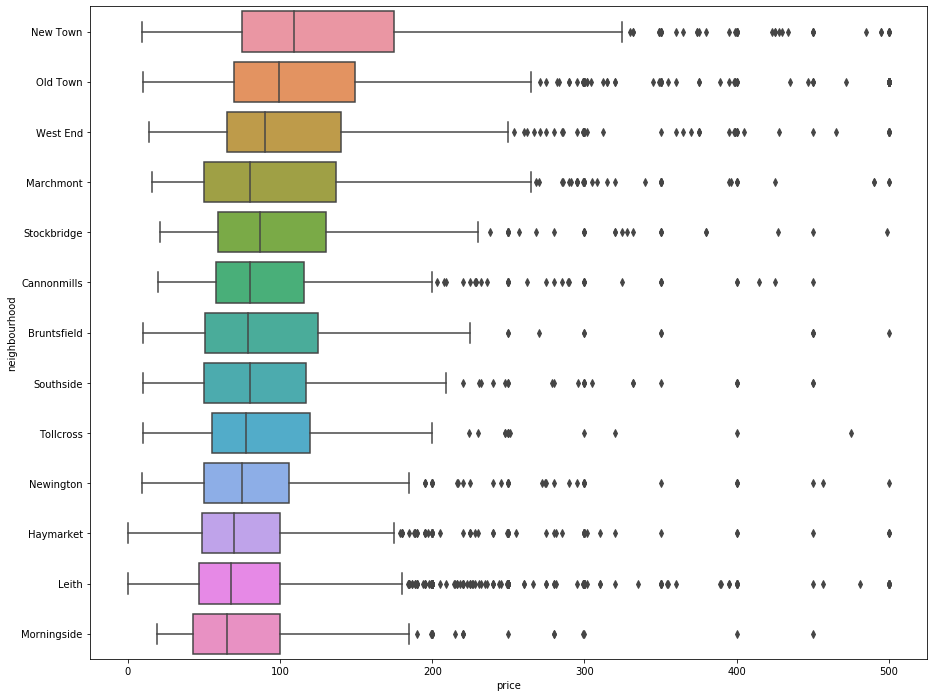

In [24]:
plt.figure(figsize=(15,12))
sns.boxplot(x='price', y='neighbourhood', data=df, order=list(nb.index))

As expected, the more affluent, central parts of Edinburgh are pricier on average.

Interestingly, they also have the most bookings. The cheaper areas have the second most bookings, and it is the middle ground properties (based on mean price) that have the fewest bookings.

Also interesting is that every neighbourhood has a vast amount of outliers, and almost all neighbourhoods have some properties priced at 500.

## 4. Reviews

Now let's look at how reviews affect price and popularity. We'll look at three features:
- number of reviews
- no reviews vs any number of reviews
- review score

In [25]:
df[['number_of_reviews', 'review_scores_rating']].describe()

,number_of_reviews,review_scores_rating
count,12350.000000,10800.000000
mean,44.501538,95.140000
std,74.858516,6.705438
min,0.000000,20.000000
25%,3.000000,93.000000
50%,14.000000,97.000000
75%,53.000000,100.000000
max,874.000000,100.000000


In [26]:
df['no_reviews'] = df['number_of_reviews'].apply(lambda x: 1 if x == 0 else 0)

In [27]:
df['no_reviews'].value_counts()

0    10930
1     1420
Name: no_reviews, dtype: int64

### no_reviews

In [28]:
df.groupby(by='no_reviews').mean()[metrics].sort_values(by='price', ascending=False)

,price,price_per_bedroom,bookings_90
no_reviews,,,
1,121.900000,86.912293,32.191549
0,93.230284,62.114144,31.661848


Interestingly, properties with no reviews are more expensive! Could first time users be more optimistic about what money they can make?

Let's clean the host_since column to investigate.

In [29]:
def days_since_compile(col, cmp_dt='2020-05-27'):
    '''Takes an input date column from the df. Converts that column into a count
    of the number of days ago it was to the date this dataset was compiled.
    '''
    df[col] = pd.to_datetime(df[col], yearfirst=True)
    df[col] = df[col].apply(lambda x: (pd.to_datetime(cmp_dt, yearfirst=True) - x).days)

days_since_compile('host_since')

In [30]:
df.groupby(by='no_reviews').mean()['host_since']

no_reviews
0    1631.693138
1    1388.491191
Name: host_since, dtype: float64

Hosts of properties with no reviews do skew 'younger' on the site.

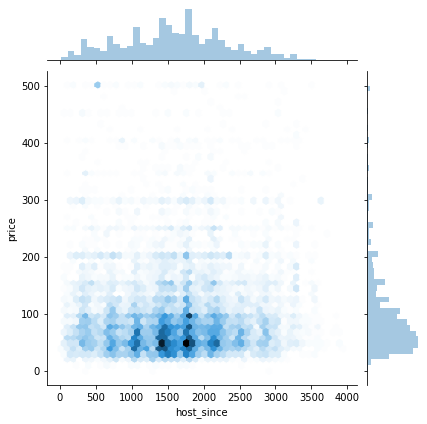

In [31]:
sns.jointplot(x='host_since', y='price', data=df, kind='hex')

However, no very clear correlation between the host's time on the site and price. While host's time on site explains part of the reason why properties with no reviews are more expensive, it isn't the full story.

### number_of_reviews

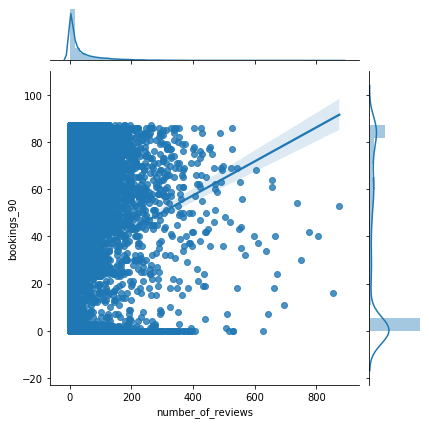

In [32]:
sns.jointplot(x='number_of_reviews', y='bookings_90', data=df, kind='reg')

As expected, number of reviews correlates positively with the number of bookings.

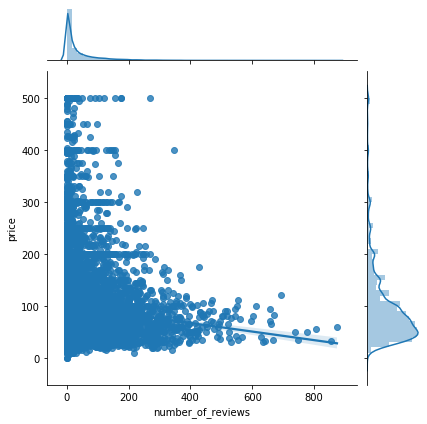

In [33]:
sns.jointplot(x='number_of_reviews', y='price', data=df, kind='reg')

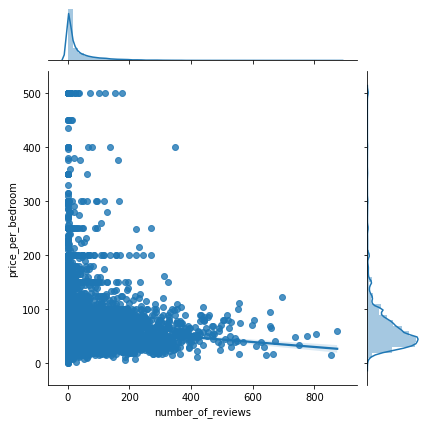

In [34]:
sns.jointplot(x='number_of_reviews', y='price_per_bedroom', data=df, kind='reg')

The number of reviews actually correlates with a smaller price! Could this be because people are more likely to bother writing a negative review to vent frustration?

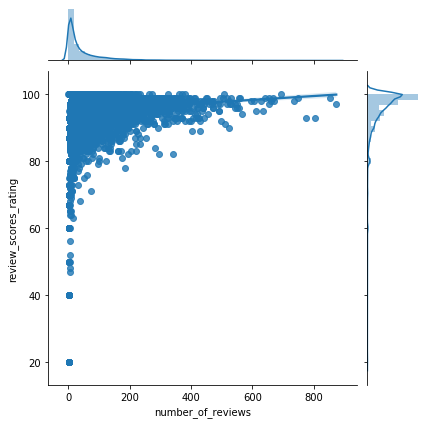

In [35]:
sns.jointplot(x='number_of_reviews', y='review_scores_rating', data=df, kind='reg')

Clearly not, as number of reviews correlates positively with review_scores_rating!

### review_scores_rating

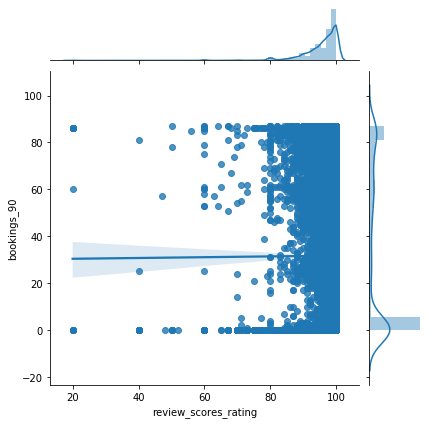

In [36]:
sns.jointplot(x='review_scores_rating', y='bookings_90', data=df, kind='reg')

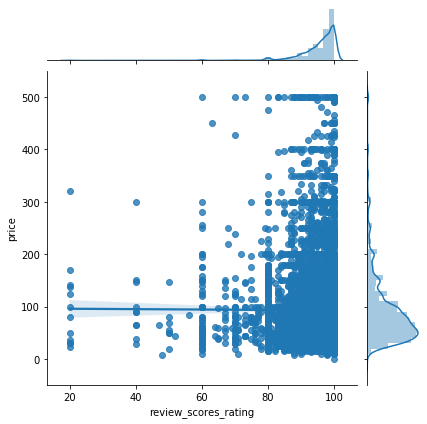

In [37]:
sns.jointplot(x='review_scores_rating', y='price', data=df, kind='reg')

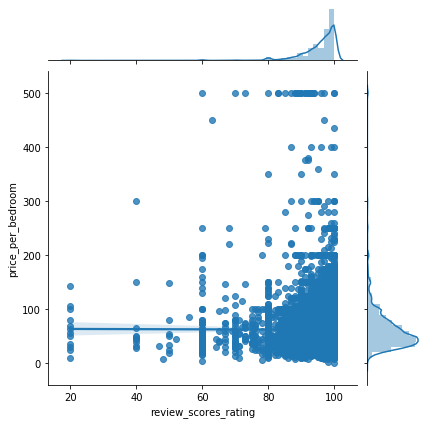

In [38]:
sns.jointplot(x='review_scores_rating', y='price_per_bedroom', data=df, kind='reg')

No strong correlations to be found with the review rating and our metrics.

## 5. Host

Now let's look at some key host metrics:
- host_since
- host_has_profile_pic
- host_is_superhost
- host_identity_verified
- gender

### host_since

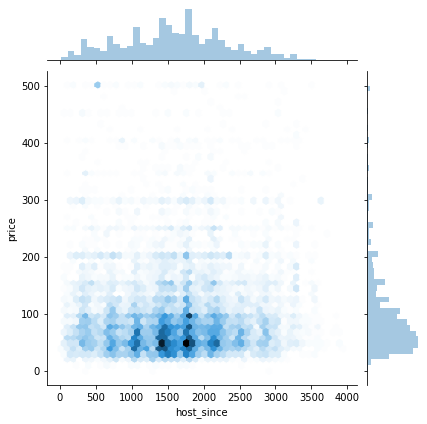

In [39]:
sns.jointplot(x='host_since', y='price', data=df, kind='hex')

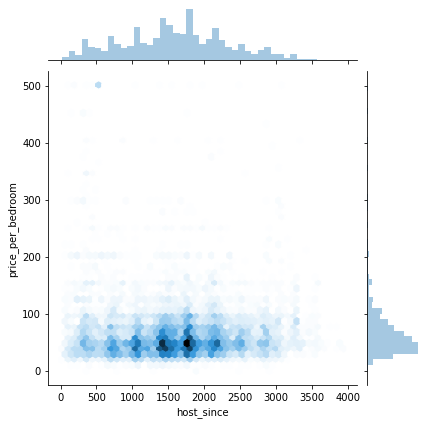

In [40]:
sns.jointplot(x='host_since', y='price_per_bedroom', data=df, kind='hex')

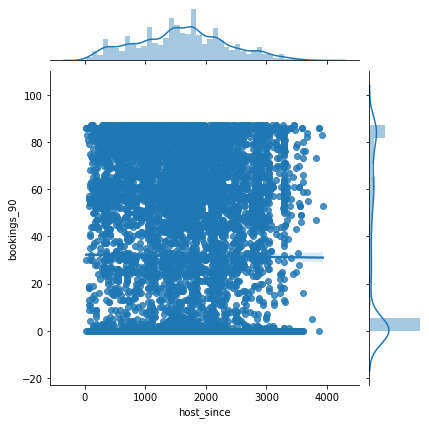

In [41]:
sns.jointplot(x='host_since', y='bookings_90', data=df, kind='reg')

No strong correlations to be found.

### host_has_profile_pic

In [42]:
df['host_has_profile_pic'].describe()

count     12349
unique        2
top           t
freq      12328
Name: host_has_profile_pic, dtype: object

In [43]:
#converting column for clarity. Note that one value missing, but this lambda
#expression effectively fills it with the median (t)
df['host_has_profile_pic'] = df['host_has_profile_pic'].apply(lambda x: False if x=='f' else True)

In [44]:
df.groupby(by='host_has_profile_pic').mean()[metrics]

,price,price_per_bedroom,bookings_90
host_has_profile_pic,,,
False,109.571429,85.968254,26.47619
True,96.504502,64.929655,31.73169


Those without a profile pic tend to charge more per bedroom. Other metrics seem a little too close to say.

### host_is_superhost

In [45]:
df['host_is_superhost'].describe()

count     12349
unique        2
top           f
freq       8320
Name: host_is_superhost, dtype: object

In [46]:
df['host_is_superhost'] = df['host_is_superhost'].apply(lambda x: True if x=='t' else False)

In [47]:
df.groupby(by='host_is_superhost').mean()[metrics]

,price,price_per_bedroom,bookings_90
host_is_superhost,,,
False,98.576012,66.202342,27.726716
True,92.294366,62.410863,39.975676


Price difference is negligible, but superhosts do get many more bookings.

### host_identity_verified

In [48]:
df['host_identity_verified'].describe()

count     12349
unique        2
top           f
freq       8200
Name: host_identity_verified, dtype: object

In [49]:
df['host_identity_verified'] = df['host_identity_verified'].apply(lambda x: True if x=='t' else False)

In [50]:
df.groupby(by='host_identity_verified').mean()[metrics]

,price,price_per_bedroom,bookings_90
host_identity_verified,,,
False,97.390806,65.817155,32.741251
True,94.818752,63.281892,29.709569


No strong correlations here. Surprisingly, number of bookings doesn't correlate with this column.

### gender

Using the name field, we can get a crude understanding of the gender of the host.

In [51]:
#the names corpus is ordered so that the first 5001 names (0-5000) are female
#and the rest are male

female_names = names.words()[:5001]
male_names = names.words()[5001:]

def gender_name_funct(x):
    if x in female_names:
        return 'female'
    elif x in male_names:
        return 'male'
    else:
        return 'unknown'

df['name_gender'] = df['host_name'].apply(gender_name_funct)

In [52]:
df['name_gender'].value_counts()

female     5773
male       3289
unknown    3288
Name: name_gender, dtype: int64

Sadly, quite a few left uncategorised.

In [53]:
df.groupby(by='name_gender').mean()[metrics]

,price,price_per_bedroom,bookings_90
name_gender,,,
female,94.032912,62.763482,30.696345
male,97.584372,63.312890,31.050775
unknown,99.847324,70.484603,34.197080


No strong correlations here.

## 6. Linear Regression Model

Let's see whether a linear regression model could be used to identify significant columns not considered in the analysis above.

Since there are so many columns in the dataset (many of which essentially duplicate data from other columns), the risk of overfitting the data is high. Thus, will try and limit the columns as far as possible.

### Dealing with Categorical Data
- host_has_profile_pic
- host_is_superhost
- host_identity_verified
- host_location
- host_response_rate
- host_acceptance_rate
- amenities
- host_response_time
- cancellation_policy
- property_type
- bed_type
- neighbourhood
- name_gender

#### host_has_profile_pic, host_is_superhost, host_identity_verified

In [54]:
for col in ['host_has_profile_pic', 'host_is_superhost', 'host_identity_verified']:
    df[col] = df[col].apply(lambda x: 1 if x==True else 0)

#### host_location

For the host location, I'm really only concerned with whether the host is in the same city as the property - Edinburgh. In future, could also look into including a UK flag, or a Scotland flag, but using all of the different locations is probably useless, as there are so many with only one instance.

In [55]:
df['host_location'].value_counts()

Edinburgh, Scotland, United Kingdom        9029
GB                                         1273
Scotland, United Kingdom                    287
London, England, United Kingdom             141
England, United Kingdom                     108
                                           ... 
Cumbernauld, Scotland, United Kingdom         1
West Palm Beach, Florida, United States       1
Queensland, Australia                         1
Kiltarlity, Scotland, United Kingdom          1
Bergen, Hordaland, Norway                     1
Name: host_location, Length: 627, dtype: int64

In [56]:
def in_Edinburgh(x):
    try:
        if 'Edinburgh' in x:
            return 1
        else:
            return 0
    except:
        return x

In [57]:
df['host_in_edi'] = df['host_location'].apply(in_Edinburgh)

#### host_response_rate, host_acceptance_rate

These columns are already in a meaningful numeric form, I just need to reformat them to remove the percent sign.

In [58]:
df['host_acceptance_rate'].value_counts()

100%    4555
98%      516
99%      379
97%      368
96%      337
        ... 
24%        1
13%        1
9%         1
18%        1
35%        1
Name: host_acceptance_rate, Length: 85, dtype: int64

In [59]:
def remove_prcnt(x):
    '''
    Removes the percent sign from a string, and converts to integer.
    Try except cycle used here, as when x is NaN, replace operation returns an error. 
    '''
    try:
        return int(x.replace('%', ''))
    except:
        return x

In [60]:
df['host_response_rate'] = df['host_response_rate'].apply(remove_prcnt)
df['host_acceptance_rate'] = df['host_acceptance_rate'].apply(remove_prcnt)

#### amenities

This column is a list of keywords.

What I want to do is make a flag for the most important keywords, indicating which listings have that element.

Another option would be NLP. My instinct is not to go for this, however - since these are lists of keywords rather than a cohesive text, I think that a flag for those keywords would work better. However, in future it would definitely be important to check whether this is the case.

The downside with my method as is, is that I have manually looked into the data, and have included here what I considered to be the most important keywords. This introduces a bit of bias, so alternatives to this method should be considered in future. For this initial investigation, this works well enough.

In [61]:
amenities = [
    'tv',
    'internet',
    'wifi',
    'wheelchair accessible',
    'kitchen',
    'washer',
    'dryer',
    '24-hour check-in',
    'self check-in',
    'bed linens',
    'hot water',
    'extra pillows and blankets',
    'pets allowed',
    'free street parking',
    'heating',
    'iron',
    'waterfront',
    'lake access',
    'beachfront',
    'family/kid friendly',
    'garden or backyard',
    'host greets you',
    'long term stays allowed',
    'luggage dropoff allowed',
    'laptop friendly workspace',
    'breakfast'
]

In [62]:
def safe_search(y, x):
    '''INPUT: y is the search term, x is the object being searched.
    If y is in x, returns 1, else 0.
    Try-except block used here to return NaN when input x is NaN.
    '''
    try:
        if y.lower() in x.lower():
            return 1
        else:
            return 0
    except:
        return x

def make_col(col, new):
    '''Takes a column name, and a singley keyword from that column. Makes a new
    column in df that flags whether that specific amenity is in that property.
    
    The name of the new column is a concatenation of the base column and the keyword,
    with an underscore in between.
    '''
    new_col = col + '_' + new
    df[new_col] = df[col].apply(lambda x: safe_search(new, x))

In [63]:
for x in amenities:
    make_col('amenities', x)

#### host_response_time, cancellation_policy

These have a small set of options, which clearly fit onto an ordered scale. Thus, making a custom label encoder here that preserves that order.

In [64]:
host_response_dict = {
    'within an hour' : 4,
    'within a few hours' : 3,
    'within a day' : 2,
    'a few days or more' : 1
}

In [65]:
cancellation_dict = {
    'flexible' : 6,
    'moderate' : 5,
    'strict' : 4,
    'strict_14_with_grace_period' : 3,
    'super_strict_30' : 2,
    'super_strict_60' : 1
}

In [66]:
def try_dict(x, dct):
    '''Used to find the value of key x in dictionary dct.
    
    Try-except block used here to deal with cases where x is NaN (return NaN) 
    '''
    try:
        return dct[x]
    except:
        return x

In [67]:
df['host_response_time'] = df['host_response_time'].apply(lambda x: try_dict(x, host_response_dict))
df['cancellation_policy'] = df['cancellation_policy'].apply(lambda x: try_dict(x, cancellation_dict))

#### one hot encoding

For these last columns, one hot encoding works best. There is no feature I want to engineer out of them, and there isn't a clear hierarchy in the options that would make label encoding the right way to go.

In [68]:
one_hot_cols = [
    'property_type',
    'room_type',
    'bed_type',
    'neighbourhood',
    'name_gender'
]

In [69]:
one_hot_df = pd.get_dummies(df[one_hot_cols], prefix=one_hot_cols)

In [70]:
df = pd.concat([df, one_hot_df], axis=1)

### Filtering Columns to Only Relevant Ones

In [71]:
#full list of columns created/dealt with above, as well as the numerical columns I want to keep.
cols = [
    'host_has_profile_pic',
    'host_is_superhost',
    'host_identity_verified',
    'host_in_edi',
    'host_response_rate',
    'host_acceptance_rate',
    'host_response_time',
    'cancellation_policy',
    'amenities_tv',
    'amenities_internet',
    'amenities_wifi',
    'amenities_wheelchair accessible',
    'amenities_kitchen',
    'amenities_washer',
    'amenities_dryer',
    'amenities_24-hour check-in',
    'amenities_self check-in',
    'amenities_bed linens',
    'amenities_hot water',
    'amenities_extra pillows and blankets',
    'amenities_pets allowed',
    'amenities_free street parking',
    'amenities_heating',
    'amenities_iron',
    'amenities_waterfront',
    'amenities_lake access',
    'amenities_beachfront',
    'amenities_family/kid friendly',
    'amenities_garden or backyard',
    'amenities_host greets you',
    'amenities_long term stays allowed',
    'amenities_luggage dropoff allowed',
    'amenities_laptop friendly workspace',
    'amenities_breakfast',
    'property_type_Aparthotel',
    'property_type_Apartment',
    'property_type_Barn',
    'property_type_Bed and breakfast',
    'property_type_Boat',
    'property_type_Boutique hotel',
    'property_type_Bungalow',
    'property_type_Cabin',
    'property_type_Camper/RV',
    'property_type_Campsite',
    'property_type_Castle',
    'property_type_Chalet',
    'property_type_Condominium',
    'property_type_Cottage',
    'property_type_Dome house',
    'property_type_Farm stay',
    'property_type_Guest suite',
    'property_type_Guesthouse',
    'property_type_Hostel',
    'property_type_Hotel',
    'property_type_House',
    'property_type_Hut',
    'property_type_Loft',
    'property_type_Other',
    'property_type_Resort',
    'property_type_Serviced apartment',
    'property_type_Tent',
    'property_type_Tiny house',
    'property_type_Townhouse',
    'property_type_Villa',
    'property_type_Windmill',
    'property_type_Yurt',
    'room_type_Entire home/apt',
    'room_type_Hotel room',
    'room_type_Private room',
    'room_type_Shared room',
    'bed_type_Airbed',
    'bed_type_Couch',
    'bed_type_Futon',
    'bed_type_Pull-out Sofa',
    'bed_type_Real Bed',
    'neighbourhood_Bruntsfield',
    'neighbourhood_Cannonmills',
    'neighbourhood_Haymarket',
    'neighbourhood_Leith',
    'neighbourhood_Marchmont',
    'neighbourhood_Morningside',
    'neighbourhood_New Town',
    'neighbourhood_Newington',
    'neighbourhood_Old Town',
    'neighbourhood_Southside',
    'neighbourhood_Stockbridge',
    'neighbourhood_Tollcross',
    'neighbourhood_West End',
    'name_gender_female',
    'name_gender_male',    #note: excluding where gender is unknown
    
    'host_listings_count',    #numerical columns
    'accommodates',
    'bathrooms',
    'minimum_nights',
    'maximum_nights',
    'review_scores_accuracy',
    'review_scores_cleanliness',
    'review_scores_checkin',
    'review_scores_communication',
    'review_scores_location',
    
    'price_per_bedroom' #target column
]

In [72]:
df = df[cols].copy()

### Filling in Missing Data

Using median here, as it works well in cases where a column has many outliers.

In [73]:
for col in list(df.columns):
    df[col] = df[col].fillna(df[col].median())

In [74]:
#double-checking all cols are numeric at this point.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12350 entries, 15420 to 43535546
Columns: 101 entries, host_has_profile_pic to price_per_bedroom
dtypes: float64(12), int64(33), uint8(56)
memory usage: 5.0 MB


### Train_Test_Split, Linear Model, and Performance

In [75]:
X = df.drop('price_per_bedroom', axis=1)
y = df['price_per_bedroom']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [76]:
lr = LinearRegression(normalize=True)

In [77]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [78]:
train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [79]:
print(r2_score(y_train, train_preds))
print(r2_score(y_test, test_preds))

0.31067157431593273
-8.230090955180879e+22


The model does not perform very well on the training set, and performs very poorly on the test set.

Clearly, the model has overfit despite limiting the number of columns as much as I did. The performance of the model could be improved by limiting the features further, investigating other ways of filling missing values, or by engineering new features (NLP could be used for the text based columns, for instance).

However, since the performance was not very good on the training data either, attempting to improve the model might be a wasted effort.